JOB CLASSIFICATION MODEL

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/job_description.csv")
df.head()

,Unnamed: 0,Category,Description,Benefits,Requirement,Requirements
0,0,Business Analyst,Description\nJob Title: Junior Business Analys...,Benefits\nMethods is passionate about its peop...,Requirements\n• Confidence in communicating an...,NaN
1,1,Business Analyst,Description\nThe Business Analyst (BA) will ca...,Benefits\nA competitive base salary\nBonus sch...,Requirements\nYou have…\nA methodical approach...,NaN
2,2,Business Analyst,Description\nWe help our clients design and de...,Benefits\nWe have 2 promotion windows open eac...,"Requirements\nYou are open, curious, and excit...",NaN
3,3,Business Analyst,Description\nFounded in 2015 and rapidly expan...,Benefits\nIn addition to a competitive package...,Requirements\nKey Responsibilities Include:\nP...,NaN
4,4,Business Analyst,Description\nWe are seeking a skilled Business...,Benefits\nFood Allowance\nGovernment Benefits\...,Requirements\nBachelor's Degree in management ...,NaN


In [3]:
df.describe()

,Unnamed: 0
count,325.000000
mean,162.000000
std,93.963645
min,0.000000
25%,81.000000
50%,162.000000
75%,243.000000
max,324.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    325 non-null    int64 
 1   Category      325 non-null    object
 2   Description   316 non-null    object
 3   Benefits      272 non-null    object
 4   Requirement   54 non-null     object
 5   Requirements  261 non-null    object
dtypes: int64(1), object(5)
memory usage: 15.4+ KB


In [5]:
df.isnull().sum()

Unnamed: 0        0
Category          0
Description       9
Benefits         53
Requirement     271
Requirements     64
dtype: int64

In [6]:
df.drop(columns=['Requirements', 'Requirement', 'Benefits', 'Unnamed: 0'], inplace=True)
df.dropna(inplace=True)

In [7]:
df.head()

,Category,Description
0,Business Analyst,Description\nJob Title: Junior Business Analys...
1,Business Analyst,Description\nThe Business Analyst (BA) will ca...
2,Business Analyst,Description\nWe help our clients design and de...
3,Business Analyst,Description\nFounded in 2015 and rapidly expan...
4,Business Analyst,Description\nWe are seeking a skilled Business...


In [8]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    return text

In [9]:
df["cleaned_text"] = df["Description"].apply(preprocess_text)

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("naver/splade-cocondenser-ensembledistil")
model = AutoModelForMaskedLM.from_pretrained("naver/splade-cocondenser-ensembledistil")


In [ ]:
def splade_encode(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits.squeeze(0)
    sparse_vector = torch.nn.functional.relu(logits).sum(dim=0).cpu().numpy()
    return sparse_vector

In [ ]:
df["splade_vector"] = df["cleaned_text"].apply(splade_encode)

X = np.stack(df["splade_vector"].values)
y = df["Category"].values

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
svm_model = SVC(kernel="linear", C=1.0, class_weight="balanced")
svm_model.fit(x_train, y_train)

SVC(class_weight='balanced', kernel='linear')

In [ ]:
y_pred = svm_model.predict(x_test)

print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

  Business Analyst       0.73      1.00      0.85        11
             Cloud       0.71      0.56      0.62         9
    Data Scientist       1.00      0.90      0.95        21
                HR       0.50      0.50      0.50         4
Software Developer       0.78      0.78      0.78        18
             UI/UX       1.00      1.00      1.00         1

          accuracy                           0.81        64
         macro avg       0.79      0.79      0.78        64
      weighted avg       0.82      0.81      0.81        64



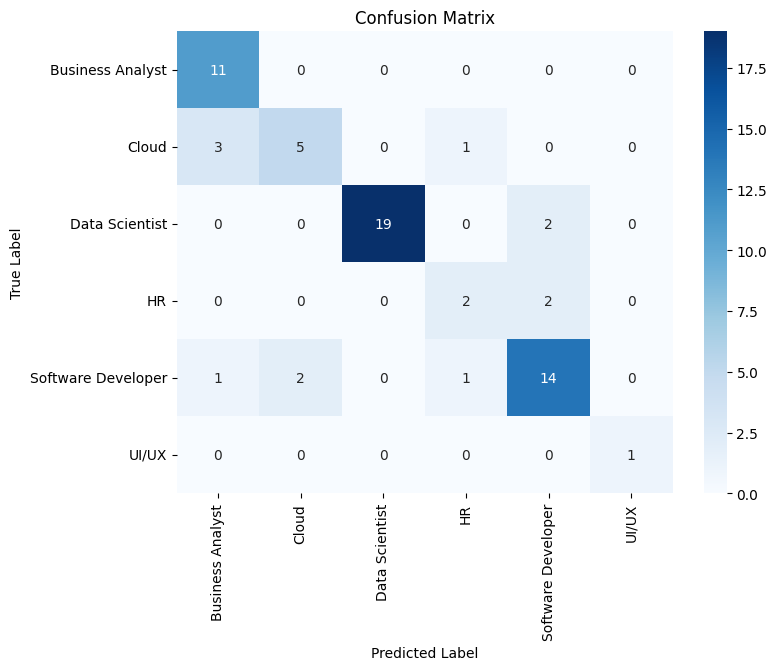

In [ ]:
cm = confusion_matrix(y_test, y_pred)

class_labels = np.unique(y_test) 

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

JOB RECOMMENDATION MODEL (CONTENT BASED FILTERING AND COLLABORATIVE BASED FILTERING)

1. CONTENT BASED FILTERING

In [17]:
from sklearn.metrics.pairwise import cosine_similarity


user_profile = input("Enter = ")
user_profile_cleaned = preprocess_text(user_profile)
user_vector = splade_encode(user_profile_cleaned)

similarity_scores = cosine_similarity([user_vector], X).flatten()

top_n = 10
top_indices = np.argsort(similarity_scores)[-top_n:][::-1]

recommendations = [
    {"Category": df.iloc[i]["Category"], "description": df.iloc[i]["Description"], "similarity": float(similarity_scores[i])}
        for i in top_indices
]

for i in recommendations:
    print(i)

{'Category': 'Data Scientist', 'description': "Description\nWe are seeking a talented Data Scientist to join our team. As a Data Scientist, you will play a key role in leveraging data to drive business insights and support data-driven decision-making. Your expertise in statistical analysis, machine learning, and data visualization will be crucial in analyzing complex datasets, developing predictive models, and generating actionable recommendations for our organization's BI initiatives.\nJob Duties:\nConduct advanced data analysis and modeling to identify trends and patterns in large datasets.\nCollaborate with the data team to define data requirements and formulate analytical approaches.\nDevelop and implement machine learning algorithms and predictive models to solve business problems.\nApply statistical techniques to analyze data and derive meaningful insights.\nDesign and develop data visualizations and dashboards to present analytical findings.\nWork with stakeholders to understand

2. COLLABORATIVE BASED FILTERING

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

num_clusters = df["Category"].nunique()

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, df["Cluster"])


KNeighborsClassifier()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

user_profile = input("Enter = ")
user_profile_cleaned = preprocess_text(user_profile)
user_vector = splade_encode(user_profile_cleaned)

predicted_cluster = knn.predict([user_vector])[0]

cluster_jobs = df[df["Cluster"] == predicted_cluster]

cluster_vectors = np.stack(cluster_jobs["splade_vector"].values)
similarity_scores = cosine_similarity([user_vector], cluster_vectors).flatten()

top_n = 5
top_indices = np.argsort(similarity_scores)[-top_n:][::-1]

recommendations = [
    {"Category": cluster_jobs.iloc[i]["Category"], "Description": cluster_jobs.iloc[i]["Description"], "Similarity": float(similarity_scores[i])}
    for i in top_indices
]

for job in recommendations:
    print(job)

{'Category': 'Business Analyst', 'Description': 'Description\nWe are seeking a skilled Business Analyst to join our team. As a Business Analyst at our fast-growing organization, you will play a pivotal role in our operations and R&D teams. You will excel in data analysis using tools like Excel, Sheets, and other relevant software. Your proficiency in project management and financial modeling will drive accurate forecasting and planning, aiding critical decision-making processes. Leveraging your experience, you will execute a diverse range of operational and analytics tasks. Your collaborative nature will shine as you work closely with cross-functional teams to drive innovation and operational excellence.\nResponsibilities:\nAnalyze key business metrics and devise improvement plans\nUtilize Excel, Sheets, and other tools for comprehensive data analysis\nApply financial modeling expertise for accurate forecasting and planning\nManage projects efficiently, ensuring timely delivery and suc

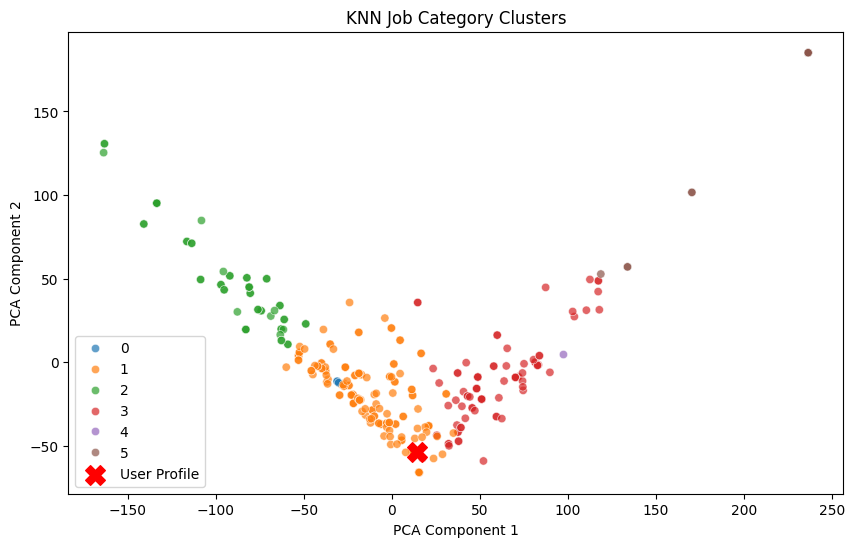

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

user_vector_pca = pca.transform([user_vector])[0]

job_clusters = df["Cluster"].values

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=job_clusters, palette="tab10", alpha=0.7)
plt.scatter(user_vector_pca[0], user_vector_pca[1], color="red", marker="X", s=200, label="User Profile")
plt.legend()
plt.title("KNN Job Category Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

num_clusters = df["Category"].nunique()
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X, df["Cluster"])  

user_profile = input("Enter your profile: ")
user_profile_cleaned = preprocess_text(user_profile)
user_vector = splade_encode(user_profile_cleaned)

cluster_distances = np.linalg.norm(kmeans.cluster_centers_ - user_vector, axis=1)

cluster_probs = 1 / (cluster_distances + 1e-6)
cluster_probs /= cluster_probs.sum()

top_n_clusters = 2
top_clusters = np.argsort(cluster_probs)[-top_n_clusters:][::-1]

print(f"User belongs to clusters: {top_clusters} with probabilities: {cluster_probs[top_clusters]}")

filtered_jobs = df[df["Cluster"].isin(top_clusters)]

cluster_vectors = np.stack(filtered_jobs["splade_vector"].values)
similarity_scores = cosine_similarity([user_vector], cluster_vectors).flatten()

top_n = 5
top_indices = np.argsort(similarity_scores)[-top_n:][::-1]

recommendations = [
    {"Category": filtered_jobs.iloc[i]["Category"], "Description": filtered_jobs.iloc[i]["Description"], "Similarity": float(similarity_scores[i])}
    for i in top_indices
]

for job in recommendations:
    print(job)

User belongs to clusters: [1 3] with probabilities: [0.32486525 0.23447478]
{'Category': 'Software Developer', 'Description': 'Description\nWhy Join Us?\nAre you looking for a role that provides opportunities to develop and grow? Take the next step in your career journey with us! We’ll provide you with a professional support structure and benefits to ensure you can thrive.\nWe offer Premium HMO, awesome technology, and above-market remuneration. Our high performers are frequently invited to visit their colleagues internationally for professional development.\nWe’re always searching for great talent to join our team. If you’d like be part of a fast-growing industry leader with an exceptional company culture, we’d love to hear from you:\nWe are looking for an inspired, motivated, and experienced Front-End Developer to join our team and help us deliver engaging web applications for our clients all around the world. Our company ethos is to build exciting user experiences for our clients an